Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/FYODB/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 6400 files belonging to 160 classes.
Using 5120 files for training.
Using 1280 files for validation.

Total number of samples in train_dataset: 4096 (128 batches of 32)
Total number of samples in validation_dataset: 1280 (40 batches of 32)
Total number of samples in test_dataset: 1024 (32 batches of 32)


Prefetching data into GPU memory to optimize training process

In [4]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

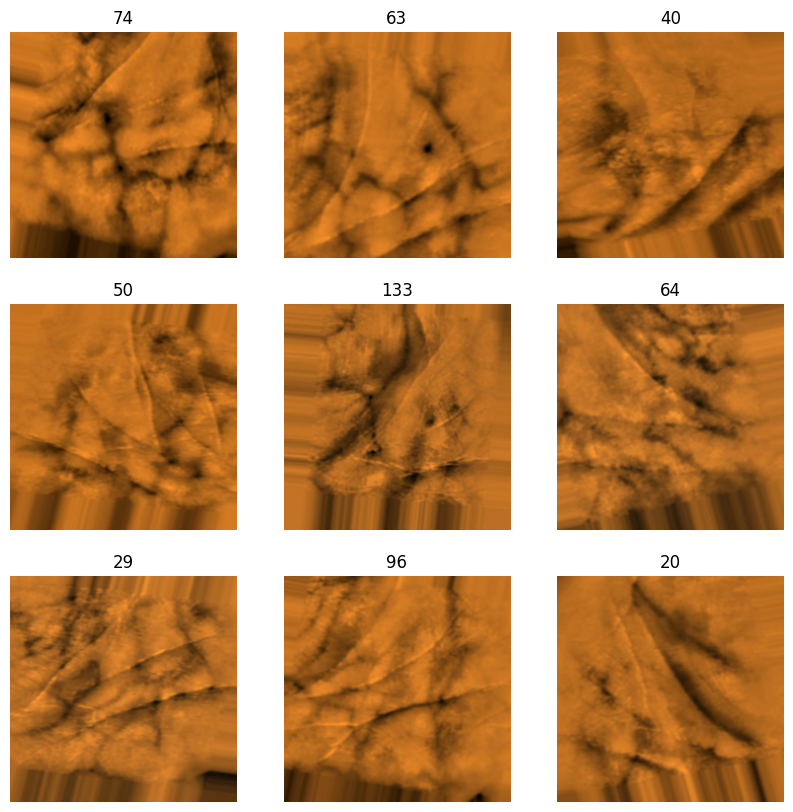

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Define some key constants

In [6]:
num_classes = 160
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [7]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [8]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [9]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [10]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": (make_alexnet_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG16": (make_vgg16_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG19": (make_vgg19_model(input_shape=image_size, num_classes=num_classes), 1e-4),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model[0].compile(
        optimizer=keras.optimizers.Adam(model[1]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model[0].fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
            reduce_lr
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
127/128 [============================>.] - ETA: 0s - loss: 4.9991 - accuracy: 0.0197

  3%|▎         | 1/30 [00:25<12:07, 25.09s/it]

128/128 [==============================] - 25s 33ms/step - loss: 4.9956 - accuracy: 0.0200 - val_loss: 5.5018 - val_accuracy: 0.0070 - lr: 1.0000e-04
Epoch 2/30
127/128 [============================>.] - ETA: 0s - loss: 4.4699 - accuracy: 0.0684

  7%|▋         | 2/30 [00:29<05:58, 12.79s/it]

128/128 [==============================] - 4s 32ms/step - loss: 4.4690 - accuracy: 0.0686 - val_loss: 4.3315 - val_accuracy: 0.0898 - lr: 1.0000e-04
Epoch 3/30
127/128 [============================>.] - ETA: 0s - loss: 3.7112 - accuracy: 0.1617

 10%|█         | 3/30 [00:33<04:00,  8.92s/it]

128/128 [==============================] - 4s 33ms/step - loss: 3.7086 - accuracy: 0.1621 - val_loss: 3.8893 - val_accuracy: 0.1422 - lr: 1.0000e-04
Epoch 4/30
128/128 [==============================] - ETA: 0s - loss: 2.6564 - accuracy: 0.3518

 13%|█▎        | 4/30 [00:37<03:04,  7.09s/it]

128/128 [==============================] - 4s 33ms/step - loss: 2.6564 - accuracy: 0.3518 - val_loss: 3.7175 - val_accuracy: 0.1883 - lr: 1.0000e-04
Epoch 5/30
128/128 [==============================] - ETA: 0s - loss: 1.6775 - accuracy: 0.5652

 17%|█▋        | 5/30 [00:41<02:30,  6.02s/it]

128/128 [==============================] - 4s 31ms/step - loss: 1.6775 - accuracy: 0.5652 - val_loss: 1.7578 - val_accuracy: 0.5508 - lr: 1.0000e-04
Epoch 6/30
128/128 [==============================] - ETA: 0s - loss: 0.9444 - accuracy: 0.7449

 20%|██        | 6/30 [00:46<02:08,  5.35s/it]

128/128 [==============================] - 4s 31ms/step - loss: 0.9444 - accuracy: 0.7449 - val_loss: 1.2785 - val_accuracy: 0.6711 - lr: 1.0000e-04
Epoch 7/30
127/128 [============================>.] - ETA: 0s - loss: 0.5519 - accuracy: 0.8425

 23%|██▎       | 7/30 [00:50<01:53,  4.92s/it]

128/128 [==============================] - 4s 31ms/step - loss: 0.5512 - accuracy: 0.8430 - val_loss: 0.9957 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 8/30
128/128 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.9048

 27%|██▋       | 8/30 [00:54<01:41,  4.62s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.3396 - accuracy: 0.9048 - val_loss: 0.6074 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 9/30
128/128 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9331

 30%|███       | 9/30 [00:58<01:33,  4.43s/it]

128/128 [==============================] - 4s 31ms/step - loss: 0.2298 - accuracy: 0.9331 - val_loss: 0.5083 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 10/30
128/128 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9482

 33%|███▎      | 10/30 [01:02<01:25,  4.29s/it]


Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
128/128 [==============================] - 4s 30ms/step - loss: 0.1729 - accuracy: 0.9482 - val_loss: 0.7355 - val_accuracy: 0.7953 - lr: 1.0000e-04
Epoch 11/30
127/128 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9734

 37%|███▋      | 11/30 [01:06<01:19,  4.19s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.0989 - accuracy: 0.9731 - val_loss: 0.2854 - val_accuracy: 0.9187 - lr: 5.0000e-05
Epoch 12/30
128/128 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9822

 40%|████      | 12/30 [01:10<01:14,  4.14s/it]


Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
128/128 [==============================] - 4s 31ms/step - loss: 0.0669 - accuracy: 0.9822 - val_loss: 0.3052 - val_accuracy: 0.9172 - lr: 5.0000e-05
Epoch 13/30
127/128 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9872

 43%|████▎     | 13/30 [01:14<01:09,  4.10s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.0473 - accuracy: 0.9873 - val_loss: 0.2641 - val_accuracy: 0.9266 - lr: 2.5000e-05
Epoch 14/30
127/128 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9916

 47%|████▋     | 14/30 [01:18<01:04,  4.06s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.0349 - accuracy: 0.9917 - val_loss: 0.2557 - val_accuracy: 0.9375 - lr: 2.5000e-05
Epoch 15/30
128/128 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9907

 50%|█████     | 15/30 [01:22<01:00,  4.04s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.0358 - accuracy: 0.9907 - val_loss: 0.2440 - val_accuracy: 0.9383 - lr: 2.5000e-05
Epoch 16/30
127/128 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9931

 53%|█████▎    | 16/30 [01:26<00:57,  4.10s/it]

128/128 [==============================] - 4s 32ms/step - loss: 0.0313 - accuracy: 0.9924 - val_loss: 0.2392 - val_accuracy: 0.9367 - lr: 2.5000e-05
Epoch 17/30
128/128 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9919

 57%|█████▋    | 17/30 [01:30<00:54,  4.16s/it]

128/128 [==============================] - 4s 33ms/step - loss: 0.0304 - accuracy: 0.9919 - val_loss: 0.2352 - val_accuracy: 0.9344 - lr: 2.5000e-05
Epoch 18/30
128/128 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9941

 60%|██████    | 18/30 [01:34<00:50,  4.25s/it]


Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
128/128 [==============================] - 4s 34ms/step - loss: 0.0237 - accuracy: 0.9941 - val_loss: 0.2397 - val_accuracy: 0.9344 - lr: 2.5000e-05
Epoch 19/30
128/128 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9951

 63%|██████▎   | 19/30 [01:39<00:47,  4.31s/it]

128/128 [==============================] - 4s 34ms/step - loss: 0.0205 - accuracy: 0.9951 - val_loss: 0.2308 - val_accuracy: 0.9383 - lr: 1.2500e-05
Epoch 20/30
128/128 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9946

 67%|██████▋   | 20/30 [01:43<00:42,  4.22s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 0.2238 - val_accuracy: 0.9391 - lr: 1.2500e-05
Epoch 21/30
128/128 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9941

 70%|███████   | 21/30 [01:47<00:37,  4.16s/it]


Epoch 21: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
128/128 [==============================] - 4s 30ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.2247 - val_accuracy: 0.9406 - lr: 1.2500e-05
Epoch 22/30
128/128 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9941

 73%|███████▎  | 22/30 [01:51<00:32,  4.11s/it]

128/128 [==============================] - 4s 30ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.2185 - val_accuracy: 0.9422 - lr: 6.2500e-06
Epoch 23/30
127/128 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9953

 77%|███████▋  | 23/30 [01:55<00:28,  4.09s/it]


Epoch 23: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
128/128 [==============================] - 4s 31ms/step - loss: 0.0199 - accuracy: 0.9951 - val_loss: 0.2215 - val_accuracy: 0.9430 - lr: 6.2500e-06
Epoch 24/30
127/128 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9958

 80%|████████  | 24/30 [01:59<00:24,  4.14s/it]


Epoch 24: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
128/128 [==============================] - 4s 32ms/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.2202 - val_accuracy: 0.9445 - lr: 3.1250e-06
Epoch 25/30
127/128 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9966

 83%|████████▎ | 25/30 [02:03<00:20,  4.12s/it]


Epoch 25: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
128/128 [==============================] - 4s 31ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.2200 - val_accuracy: 0.9438 - lr: 1.5625e-06
Epoch 26/30
127/128 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9968

 87%|████████▋ | 26/30 [02:07<00:16,  4.09s/it]


Epoch 26: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
128/128 [==============================] - 4s 31ms/step - loss: 0.0152 - accuracy: 0.9968 - val_loss: 0.2197 - val_accuracy: 0.9453 - lr: 7.8125e-07
Epoch 27/30
127/128 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9970

 90%|█████████ | 27/30 [02:11<00:12,  4.09s/it]


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
128/128 [==============================] - 4s 31ms/step - loss: 0.0147 - accuracy: 0.9971 - val_loss: 0.2197 - val_accuracy: 0.9453 - lr: 3.9062e-07
Epoch 28/30
128/128 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9951

 93%|█████████▎| 28/30 [02:15<00:08,  4.06s/it]


Epoch 28: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
128/128 [==============================] - 4s 30ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.2195 - val_accuracy: 0.9453 - lr: 1.9531e-07
Epoch 29/30
128/128 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9954

 97%|█████████▋| 29/30 [02:20<00:04,  4.10s/it]


Epoch 29: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
128/128 [==============================] - 4s 31ms/step - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.2195 - val_accuracy: 0.9453 - lr: 9.7656e-08
Epoch 30/30
128/128 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9949

100%|██████████| 30/30 [02:24<00:00,  4.07s/it]


Epoch 30: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
128/128 [==============================] - 4s 30ms/step - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.2193 - val_accuracy: 0.9461 - lr: 4.8828e-08


100%|██████████| 30/30 [02:24<00:00,  4.80s/it]


Finished training AlexNet in 144.15s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 5.7991 - accuracy: 0.0173

  3%|▎         | 1/30 [00:35<17:11, 35.57s/it]

128/128 [==============================] - 36s 236ms/step - loss: 5.7991 - accuracy: 0.0173 - val_loss: 5.1667 - val_accuracy: 0.0031 - lr: 1.0000e-04
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 4.7836 - accuracy: 0.0552

  7%|▋         | 2/30 [01:07<15:29, 33.18s/it]


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
128/128 [==============================] - 32s 245ms/step - loss: 4.7836 - accuracy: 0.0552 - val_loss: 5.1795 - val_accuracy: 0.0078 - lr: 1.0000e-04
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 4.0847 - accuracy: 0.1240

 10%|█         | 3/30 [01:37<14:27, 32.13s/it]

128/128 [==============================] - 31s 241ms/step - loss: 4.0847 - accuracy: 0.1240 - val_loss: 4.4013 - val_accuracy: 0.0461 - lr: 5.0000e-05
Epoch 4/30
128/128 [==============================] - ETA: 0s - loss: 3.4519 - accuracy: 0.2163

 13%|█▎        | 4/30 [02:08<13:42, 31.65s/it]

128/128 [==============================] - 31s 241ms/step - loss: 3.4519 - accuracy: 0.2163 - val_loss: 3.4036 - val_accuracy: 0.2422 - lr: 5.0000e-05
Epoch 5/30
128/128 [==============================] - ETA: 0s - loss: 2.8326 - accuracy: 0.3315

 17%|█▋        | 5/30 [02:40<13:10, 31.62s/it]

128/128 [==============================] - 32s 245ms/step - loss: 2.8326 - accuracy: 0.3315 - val_loss: 2.4988 - val_accuracy: 0.4219 - lr: 5.0000e-05
Epoch 6/30
128/128 [==============================] - ETA: 0s - loss: 2.1708 - accuracy: 0.4683

 20%|██        | 6/30 [03:12<12:44, 31.87s/it]

128/128 [==============================] - 32s 252ms/step - loss: 2.1708 - accuracy: 0.4683 - val_loss: 1.8713 - val_accuracy: 0.5906 - lr: 5.0000e-05
Epoch 7/30
128/128 [==============================] - ETA: 0s - loss: 1.5551 - accuracy: 0.6077

 23%|██▎       | 7/30 [03:44<12:12, 31.86s/it]

128/128 [==============================] - 32s 248ms/step - loss: 1.5551 - accuracy: 0.6077 - val_loss: 1.3884 - val_accuracy: 0.6570 - lr: 5.0000e-05
Epoch 8/30
128/128 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.7095

 27%|██▋       | 8/30 [04:16<11:39, 31.78s/it]

128/128 [==============================] - 32s 246ms/step - loss: 1.1089 - accuracy: 0.7095 - val_loss: 1.0948 - val_accuracy: 0.7258 - lr: 5.0000e-05
Epoch 9/30
128/128 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.7935

 30%|███       | 9/30 [04:47<11:06, 31.74s/it]

128/128 [==============================] - 32s 246ms/step - loss: 0.7752 - accuracy: 0.7935 - val_loss: 0.8329 - val_accuracy: 0.7891 - lr: 5.0000e-05
Epoch 10/30
128/128 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.8496

 33%|███▎      | 10/30 [05:20<10:38, 31.91s/it]

128/128 [==============================] - 32s 251ms/step - loss: 0.5696 - accuracy: 0.8496 - val_loss: 0.7091 - val_accuracy: 0.8148 - lr: 5.0000e-05
Epoch 11/30
128/128 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8867

 37%|███▋      | 11/30 [05:52<10:06, 31.94s/it]

128/128 [==============================] - 32s 249ms/step - loss: 0.4162 - accuracy: 0.8867 - val_loss: 0.6107 - val_accuracy: 0.8383 - lr: 5.0000e-05
Epoch 12/30
128/128 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9250

 40%|████      | 12/30 [06:23<09:33, 31.88s/it]

128/128 [==============================] - 32s 247ms/step - loss: 0.2961 - accuracy: 0.9250 - val_loss: 0.5032 - val_accuracy: 0.8672 - lr: 5.0000e-05
Epoch 13/30
128/128 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9436

 43%|████▎     | 13/30 [06:55<09:00, 31.77s/it]

128/128 [==============================] - 32s 245ms/step - loss: 0.2240 - accuracy: 0.9436 - val_loss: 0.4543 - val_accuracy: 0.8859 - lr: 5.0000e-05
Epoch 14/30
128/128 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9536

 47%|████▋     | 14/30 [07:30<08:45, 32.85s/it]

128/128 [==============================] - 35s 276ms/step - loss: 0.1846 - accuracy: 0.9536 - val_loss: 0.4032 - val_accuracy: 0.9000 - lr: 5.0000e-05
Epoch 15/30
128/128 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9521

 50%|█████     | 15/30 [08:03<08:10, 32.67s/it]

128/128 [==============================] - 32s 251ms/step - loss: 0.1808 - accuracy: 0.9521 - val_loss: 0.3896 - val_accuracy: 0.9102 - lr: 5.0000e-05
Epoch 16/30
128/128 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9688

 53%|█████▎    | 16/30 [08:35<07:36, 32.61s/it]

128/128 [==============================] - 32s 253ms/step - loss: 0.1264 - accuracy: 0.9688 - val_loss: 0.3798 - val_accuracy: 0.9047 - lr: 5.0000e-05
Epoch 17/30
128/128 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9768

 57%|█████▋    | 17/30 [09:07<07:01, 32.45s/it]

128/128 [==============================] - 32s 250ms/step - loss: 0.0958 - accuracy: 0.9768 - val_loss: 0.3343 - val_accuracy: 0.9156 - lr: 5.0000e-05
Epoch 18/30
128/128 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9783

 60%|██████    | 18/30 [09:39<06:29, 32.43s/it]


Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
128/128 [==============================] - 32s 252ms/step - loss: 0.0880 - accuracy: 0.9783 - val_loss: 0.3349 - val_accuracy: 0.9180 - lr: 5.0000e-05
Epoch 19/30
128/128 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9866

 63%|██████▎   | 19/30 [10:11<05:53, 32.17s/it]

128/128 [==============================] - 32s 246ms/step - loss: 0.0670 - accuracy: 0.9866 - val_loss: 0.3020 - val_accuracy: 0.9211 - lr: 2.5000e-05
Epoch 20/30
128/128 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9900

 67%|██████▋   | 20/30 [10:43<05:21, 32.18s/it]

128/128 [==============================] - 32s 251ms/step - loss: 0.0539 - accuracy: 0.9900 - val_loss: 0.2897 - val_accuracy: 0.9273 - lr: 2.5000e-05
Epoch 21/30
128/128 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9905

 70%|███████   | 21/30 [11:15<04:48, 32.09s/it]

128/128 [==============================] - 32s 248ms/step - loss: 0.0446 - accuracy: 0.9905 - val_loss: 0.2837 - val_accuracy: 0.9281 - lr: 2.5000e-05
Epoch 22/30
128/128 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9878

 73%|███████▎  | 22/30 [11:47<04:16, 32.08s/it]


Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
128/128 [==============================] - 32s 249ms/step - loss: 0.0475 - accuracy: 0.9878 - val_loss: 0.2855 - val_accuracy: 0.9211 - lr: 2.5000e-05
Epoch 23/30
128/128 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9919

 77%|███████▋  | 23/30 [12:19<03:44, 32.03s/it]

128/128 [==============================] - 32s 249ms/step - loss: 0.0359 - accuracy: 0.9919 - val_loss: 0.2750 - val_accuracy: 0.9266 - lr: 1.2500e-05
Epoch 24/30
128/128 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9934

 80%|████████  | 24/30 [12:51<03:11, 31.99s/it]

128/128 [==============================] - 32s 248ms/step - loss: 0.0314 - accuracy: 0.9934 - val_loss: 0.2674 - val_accuracy: 0.9266 - lr: 1.2500e-05
Epoch 25/30
128/128 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9944

 83%|████████▎ | 25/30 [13:23<02:40, 32.04s/it]

128/128 [==============================] - 32s 250ms/step - loss: 0.0317 - accuracy: 0.9944 - val_loss: 0.2600 - val_accuracy: 0.9312 - lr: 1.2500e-05
Epoch 26/30
128/128 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9954

 87%|████████▋ | 26/30 [13:55<02:07, 31.96s/it]

128/128 [==============================] - 32s 247ms/step - loss: 0.0314 - accuracy: 0.9954 - val_loss: 0.2519 - val_accuracy: 0.9383 - lr: 1.2500e-05
Epoch 27/30
128/128 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9951

 90%|█████████ | 27/30 [14:27<01:35, 31.88s/it]

128/128 [==============================] - 32s 247ms/step - loss: 0.0276 - accuracy: 0.9951 - val_loss: 0.2458 - val_accuracy: 0.9398 - lr: 1.2500e-05
Epoch 28/30
128/128 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9949

 93%|█████████▎| 28/30 [14:58<01:03, 31.74s/it]


Epoch 28: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
128/128 [==============================] - 31s 244ms/step - loss: 0.0288 - accuracy: 0.9949 - val_loss: 0.2522 - val_accuracy: 0.9422 - lr: 1.2500e-05
Epoch 29/30
128/128 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9927

 97%|█████████▋| 29/30 [15:30<00:31, 31.75s/it]

128/128 [==============================] - 32s 248ms/step - loss: 0.0315 - accuracy: 0.9927 - val_loss: 0.2444 - val_accuracy: 0.9438 - lr: 6.2500e-06
Epoch 30/30
128/128 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9951

100%|██████████| 30/30 [16:02<00:00, 31.78s/it]

128/128 [==============================] - 32s 248ms/step - loss: 0.0261 - accuracy: 0.9951 - val_loss: 0.2411 - val_accuracy: 0.9430 - lr: 6.2500e-06


100%|██████████| 30/30 [16:02<00:00, 32.07s/it]


Finished training VGG16 in 962.15s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
128/128 [==============================] - ETA: 0s - loss: 5.9433 - accuracy: 0.0110

  3%|▎         | 1/30 [00:38<18:33, 38.39s/it]

128/128 [==============================] - 38s 286ms/step - loss: 5.9433 - accuracy: 0.0110 - val_loss: 5.1222 - val_accuracy: 0.0039 - lr: 1.0000e-04
Epoch 2/30
128/128 [==============================] - ETA: 0s - loss: 5.0941 - accuracy: 0.0271

  7%|▋         | 2/30 [01:13<17:02, 36.53s/it]

128/128 [==============================] - 35s 274ms/step - loss: 5.0941 - accuracy: 0.0271 - val_loss: 4.8798 - val_accuracy: 0.0141 - lr: 1.0000e-04
Epoch 3/30
128/128 [==============================] - ETA: 0s - loss: 4.5521 - accuracy: 0.0681

 10%|█         | 3/30 [01:47<15:55, 35.39s/it]

128/128 [==============================] - 34s 265ms/step - loss: 4.5521 - accuracy: 0.0681 - val_loss: 4.2463 - val_accuracy: 0.0797 - lr: 1.0000e-04
Epoch 4/30
128/128 [==============================] - ETA: 0s - loss: 3.8395 - accuracy: 0.1460

 13%|█▎        | 4/30 [02:24<15:31, 35.82s/it]

128/128 [==============================] - 36s 284ms/step - loss: 3.8395 - accuracy: 0.1460 - val_loss: 3.2983 - val_accuracy: 0.2406 - lr: 1.0000e-04
Epoch 5/30
128/128 [==============================] - ETA: 0s - loss: 2.9453 - accuracy: 0.2888

 17%|█▋        | 5/30 [02:58<14:39, 35.19s/it]

128/128 [==============================] - 34s 265ms/step - loss: 2.9453 - accuracy: 0.2888 - val_loss: 2.3849 - val_accuracy: 0.4234 - lr: 1.0000e-04
Epoch 6/30
128/128 [==============================] - ETA: 0s - loss: 2.0674 - accuracy: 0.4802

 20%|██        | 6/30 [03:32<13:59, 34.98s/it]

128/128 [==============================] - 35s 269ms/step - loss: 2.0674 - accuracy: 0.4802 - val_loss: 1.6649 - val_accuracy: 0.5992 - lr: 1.0000e-04
Epoch 7/30
128/128 [==============================] - ETA: 0s - loss: 1.3021 - accuracy: 0.6484

 23%|██▎       | 7/30 [04:06<13:16, 34.65s/it]

128/128 [==============================] - 34s 265ms/step - loss: 1.3021 - accuracy: 0.6484 - val_loss: 1.0865 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 8/30
128/128 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.7898

 27%|██▋       | 8/30 [04:41<12:42, 34.64s/it]

128/128 [==============================] - 35s 270ms/step - loss: 0.7687 - accuracy: 0.7898 - val_loss: 0.8741 - val_accuracy: 0.7719 - lr: 1.0000e-04
Epoch 9/30
128/128 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8584

 30%|███       | 9/30 [05:15<12:06, 34.60s/it]

128/128 [==============================] - 35s 269ms/step - loss: 0.5175 - accuracy: 0.8584 - val_loss: 0.5868 - val_accuracy: 0.8469 - lr: 1.0000e-04
Epoch 10/30
128/128 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.9119

 33%|███▎      | 10/30 [05:50<11:31, 34.59s/it]

128/128 [==============================] - 35s 269ms/step - loss: 0.3238 - accuracy: 0.9119 - val_loss: 0.4401 - val_accuracy: 0.8836 - lr: 1.0000e-04
Epoch 11/30
128/128 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9370

 37%|███▋      | 11/30 [06:25<10:57, 34.62s/it]


Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
128/128 [==============================] - 35s 270ms/step - loss: 0.2268 - accuracy: 0.9370 - val_loss: 0.4530 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 12/30
128/128 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9675

 40%|████      | 12/30 [06:59<10:22, 34.56s/it]

128/128 [==============================] - 34s 268ms/step - loss: 0.1330 - accuracy: 0.9675 - val_loss: 0.3380 - val_accuracy: 0.9125 - lr: 5.0000e-05
Epoch 13/30
128/128 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9763

 43%|████▎     | 13/30 [07:34<09:47, 34.57s/it]

128/128 [==============================] - 35s 270ms/step - loss: 0.0932 - accuracy: 0.9763 - val_loss: 0.3109 - val_accuracy: 0.9187 - lr: 5.0000e-05
Epoch 14/30
128/128 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9827

 47%|████▋     | 14/30 [08:08<09:11, 34.48s/it]

128/128 [==============================] - 34s 267ms/step - loss: 0.0721 - accuracy: 0.9827 - val_loss: 0.3036 - val_accuracy: 0.9195 - lr: 5.0000e-05
Epoch 15/30
128/128 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9854

 50%|█████     | 15/30 [08:43<08:41, 34.78s/it]

128/128 [==============================] - 35s 276ms/step - loss: 0.0603 - accuracy: 0.9854 - val_loss: 0.2902 - val_accuracy: 0.9211 - lr: 5.0000e-05
Epoch 16/30
128/128 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9888

 53%|█████▎    | 16/30 [09:19<08:08, 34.92s/it]

128/128 [==============================] - 35s 274ms/step - loss: 0.0546 - accuracy: 0.9888 - val_loss: 0.2657 - val_accuracy: 0.9242 - lr: 5.0000e-05
Epoch 17/30
128/128 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9902

 57%|█████▋    | 17/30 [09:53<07:31, 34.70s/it]


Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
128/128 [==============================] - 34s 266ms/step - loss: 0.0466 - accuracy: 0.9902 - val_loss: 0.2886 - val_accuracy: 0.9219 - lr: 5.0000e-05
Epoch 18/30
128/128 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9915

 60%|██████    | 18/30 [10:28<06:57, 34.80s/it]

128/128 [==============================] - 35s 273ms/step - loss: 0.0423 - accuracy: 0.9915 - val_loss: 0.2584 - val_accuracy: 0.9289 - lr: 2.5000e-05
Epoch 19/30
128/128 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9917

 63%|██████▎   | 19/30 [11:04<06:27, 35.19s/it]

128/128 [==============================] - 36s 281ms/step - loss: 0.0333 - accuracy: 0.9917 - val_loss: 0.2524 - val_accuracy: 0.9273 - lr: 2.5000e-05
Epoch 20/30
128/128 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9944

 67%|██████▋   | 20/30 [11:40<05:55, 35.53s/it]

128/128 [==============================] - 36s 282ms/step - loss: 0.0334 - accuracy: 0.9944 - val_loss: 0.2509 - val_accuracy: 0.9297 - lr: 2.5000e-05
Epoch 21/30
128/128 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9949

 70%|███████   | 21/30 [12:15<05:17, 35.24s/it]

128/128 [==============================] - 35s 269ms/step - loss: 0.0272 - accuracy: 0.9949 - val_loss: 0.2406 - val_accuracy: 0.9359 - lr: 2.5000e-05
Epoch 22/30
128/128 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9949

 73%|███████▎  | 22/30 [12:50<04:40, 35.12s/it]


Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
128/128 [==============================] - 35s 271ms/step - loss: 0.0255 - accuracy: 0.9949 - val_loss: 0.2448 - val_accuracy: 0.9320 - lr: 2.5000e-05
Epoch 23/30
128/128 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9958

 77%|███████▋  | 23/30 [13:24<04:05, 35.00s/it]

128/128 [==============================] - 35s 270ms/step - loss: 0.0228 - accuracy: 0.9958 - val_loss: 0.2351 - val_accuracy: 0.9344 - lr: 1.2500e-05
Epoch 24/30
128/128 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9963

 80%|████████  | 24/30 [13:59<03:29, 34.92s/it]

128/128 [==============================] - 35s 271ms/step - loss: 0.0212 - accuracy: 0.9963 - val_loss: 0.2298 - val_accuracy: 0.9367 - lr: 1.2500e-05
Epoch 25/30
128/128 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9966

 83%|████████▎ | 25/30 [14:34<02:54, 34.87s/it]

128/128 [==============================] - 35s 270ms/step - loss: 0.0228 - accuracy: 0.9966 - val_loss: 0.2281 - val_accuracy: 0.9367 - lr: 1.2500e-05
Epoch 26/30
128/128 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9949

 87%|████████▋ | 26/30 [15:08<02:18, 34.65s/it]


Epoch 26: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
128/128 [==============================] - 34s 266ms/step - loss: 0.0211 - accuracy: 0.9949 - val_loss: 0.2290 - val_accuracy: 0.9352 - lr: 1.2500e-05
Epoch 27/30
128/128 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9985

 90%|█████████ | 27/30 [15:43<01:44, 34.70s/it]

128/128 [==============================] - 35s 271ms/step - loss: 0.0157 - accuracy: 0.9985 - val_loss: 0.2250 - val_accuracy: 0.9359 - lr: 6.2500e-06
Epoch 28/30
128/128 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9971

 93%|█████████▎| 28/30 [16:18<01:09, 34.81s/it]


Epoch 28: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
128/128 [==============================] - 35s 273ms/step - loss: 0.0174 - accuracy: 0.9971 - val_loss: 0.2255 - val_accuracy: 0.9375 - lr: 6.2500e-06
Epoch 29/30
128/128 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9939

 97%|█████████▋| 29/30 [16:53<00:34, 34.79s/it]

128/128 [==============================] - 35s 271ms/step - loss: 0.0237 - accuracy: 0.9939 - val_loss: 0.2200 - val_accuracy: 0.9367 - lr: 3.1250e-06
Epoch 30/30
128/128 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9968

100%|██████████| 30/30 [17:27<00:00, 34.71s/it]

128/128 [==============================] - 35s 269ms/step - loss: 0.0196 - accuracy: 0.9968 - val_loss: 0.2183 - val_accuracy: 0.9352 - lr: 3.1250e-06


100%|██████████| 30/30 [17:27<00:00, 34.92s/it]

Finished training VGG19 in 1047.67s



Defining function to plot model performance

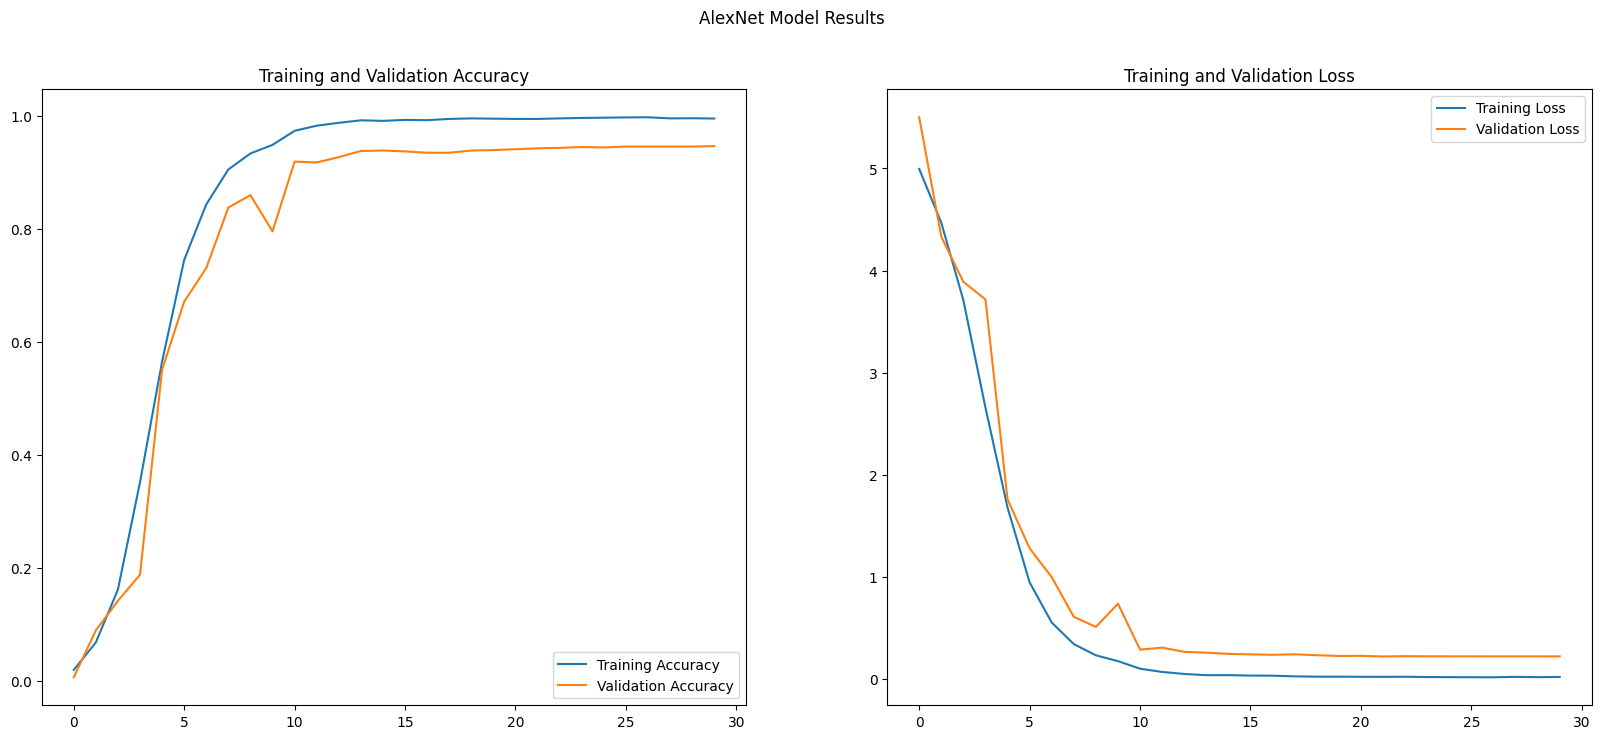

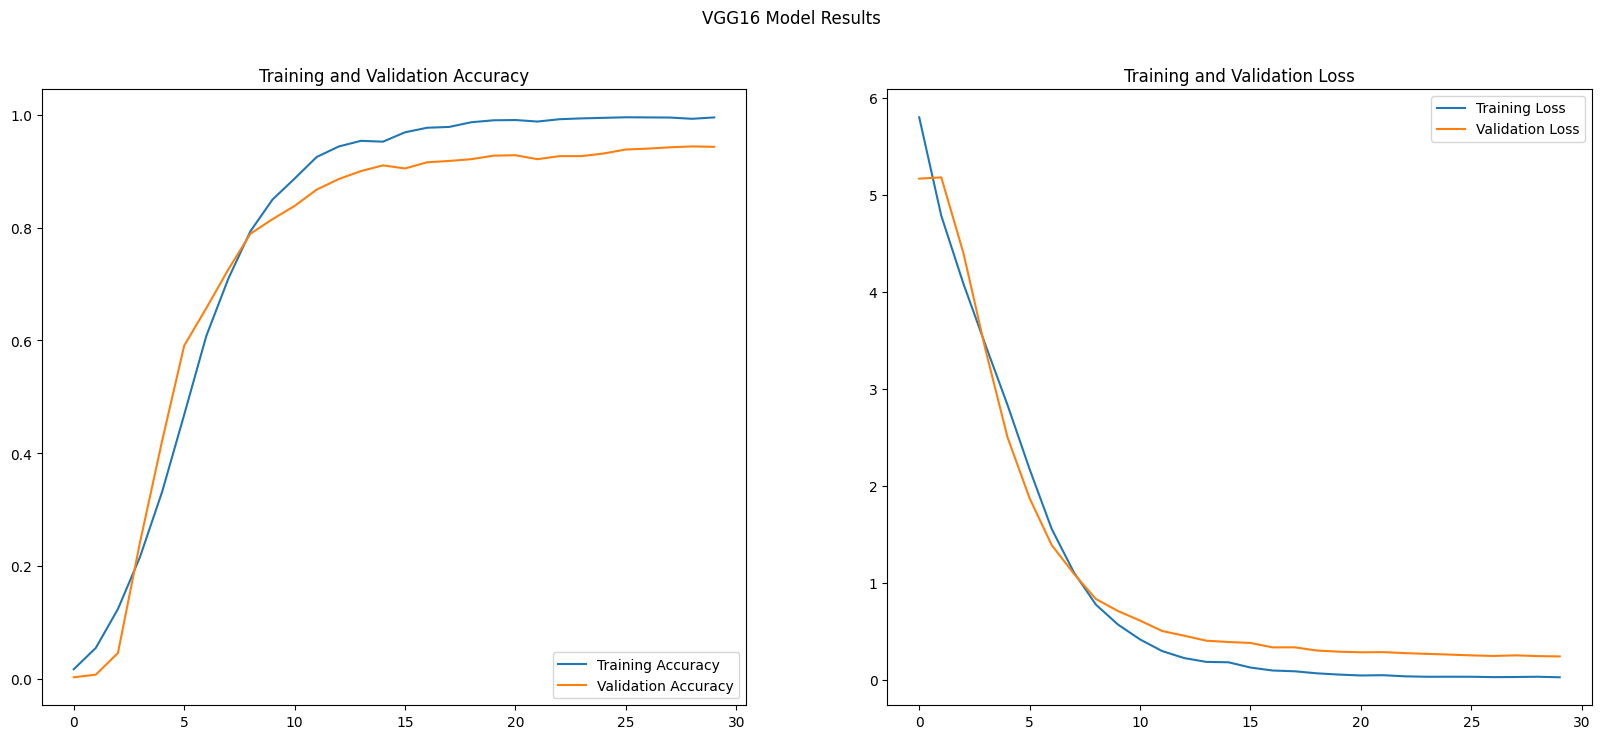

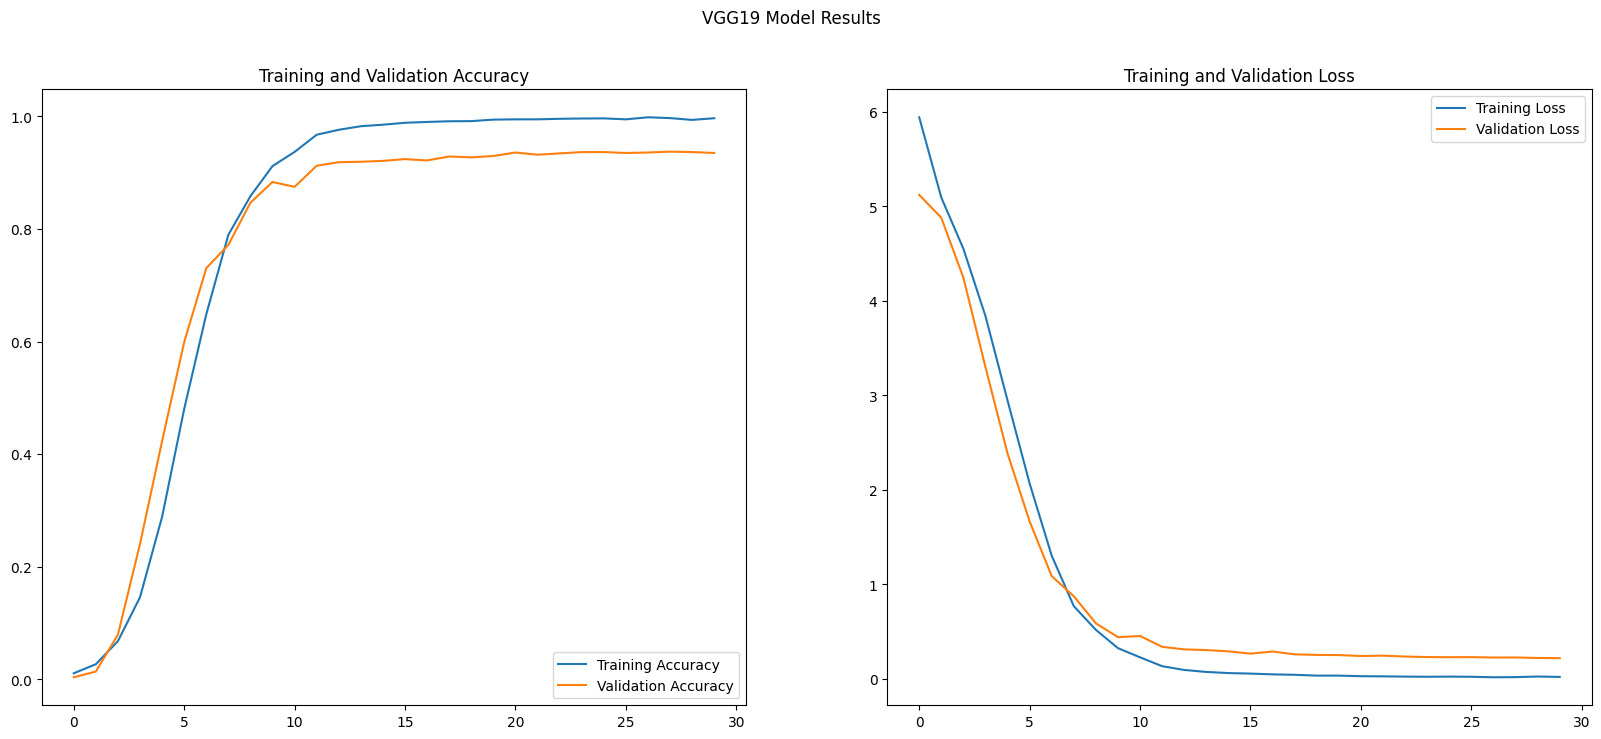

In [12]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

for name, history in model_histories.items():
    plot_model_performance(name, history)

In [13]:
model_results = {}

for name, model in models.items():
    model_results[name] = model[0].evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')


32/32 [==============================] - 3s 21ms/step - loss: 0.1569 - accuracy: 0.9590
AlexNet Model Results:
Test accuracy: 95.90%
Test loss: 0.1569

32/32 [==============================] - 4s 62ms/step - loss: 0.1774 - accuracy: 0.9570
VGG16 Model Results:
Test accuracy: 95.70%
Test loss: 0.1774

32/32 [==============================] - 4s 71ms/step - loss: 0.1487 - accuracy: 0.9551
VGG19 Model Results:
Test accuracy: 95.51%
Test loss: 0.1487



Saving models and their training histories

In [17]:
for name, model in models.items():
    model[0].save(f'Saved Models/FYODB/{name}-{model_results[name][1]*100:.2f}%.keras')
    print(f'Saved {name} Model')


for name, history in model_histories.items():
    del history.history['lr']
    with open(f'Model Histories/FYODB/{name}-{model_results[name][1]*100:.2f}%.json', 'w') as json_file:
        json.dump(history.history, json_file)


## Loading trained model

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/FYODB/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 6400 files belonging to 160 classes.
Using 5120 files for training.
Using 1280 files for validation.

Total number of samples in train_dataset: 4096 (128 batches of 32)
Total number of samples in validation_dataset: 1280 (40 batches of 32)
Total number of samples in test_dataset: 1024 (32 batches of 32)


In [3]:
alexnet_model = keras.models.load_model('Saved Models/FYODB/AlexNet-95.90%.keras')
vgg16_model = keras.models.load_model('Saved Models/FYODB/VGG16-95.70%.keras')
vgg19_model = keras.models.load_model('Saved Models/FYODB/VGG19-95.51%.keras')

Text(0.5, 1.0, 'Predicted Class: Subject 1\nActual Class: Subject 1')

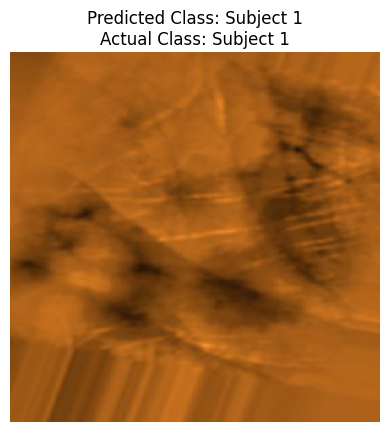

In [4]:
class_to_test = 1 # Try any number from 1 to 160

img = keras.utils.load_img(
    f"Datasets/FYODB/{class_names[class_to_test-1]}/Session 1/s{class_to_test}_1_L_S1.jpg", target_size=(224, 224)
)
plt.imshow(img)
plt.axis('off')

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

plt.title(f'Predicted Class: {class_names[prediction]}\nActual Class: {class_names[class_to_test-1]}')

In [5]:
def decision_level_fusion_paper(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            # Assign weights based on correct or incorrect recognition
            weight_alexnet = 1 if prediction_alexnet == label else 0
            weight_vgg16 = 1 if prediction_vgg16 == label else 0
            weight_vgg19 = 1 if prediction_vgg19 == label else 0

            # Calculate the final decision
            final_decision = weight_alexnet + weight_vgg16 + weight_vgg19 

            # Update accuracy metrics
            correct_predictions += 1 if final_decision >= 2 else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

paper_fusion_accuracy = decision_level_fusion_paper(test_dataset)
print(f"Accuracy: {paper_fusion_accuracy:.2%}")


Evaluating Dataset With Decision Fusion: 100%|██████████| 32/32 [03:12<00:00,  6.02s/batch]

Accuracy: 96.97%


In [6]:
def decision_level_fusion_improved(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Improved Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            predictions_list = [prediction_alexnet, prediction_vgg16, prediction_vgg19]

            joint_decision = max(set(predictions_list), key=predictions_list.count)

            # Update accuracy metrics
            correct_predictions += 1 if joint_decision == label else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

improved_fusion_accuracy = decision_level_fusion_improved(test_dataset)
print(f"Test Accuracy: {improved_fusion_accuracy:.2%}")


Evaluating Dataset With Improved Decision Fusion: 100%|██████████| 32/32 [04:44<00:00,  8.90s/batch]

Test Accuracy: 97.46%


In [7]:
y = [model.evaluate(test_dataset, verbose=0)[1] for model in [alexnet_model, vgg16_model, vgg19_model]]
y.append(paper_fusion_accuracy)
y.append(improved_fusion_accuracy)

Text(0.5, 1.0, 'FYODB Results Comparison')

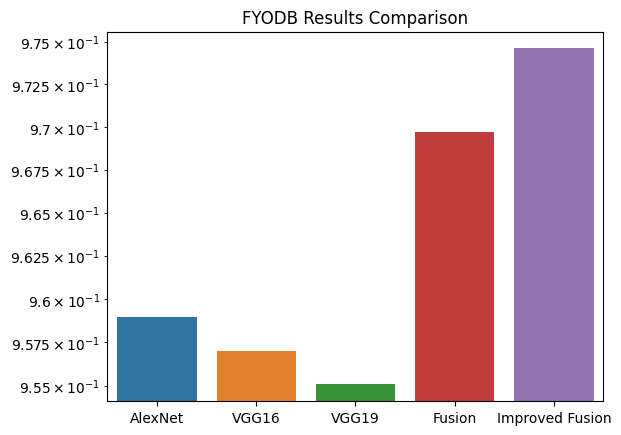

In [12]:
import seaborn as sns

plt.yscale('log')
sns.barplot(y=y, x=['AlexNet', 'VGG16', 'VGG19', 'Fusion', 'Improved Fusion'])
plt.title('FYODB Results Comparison')

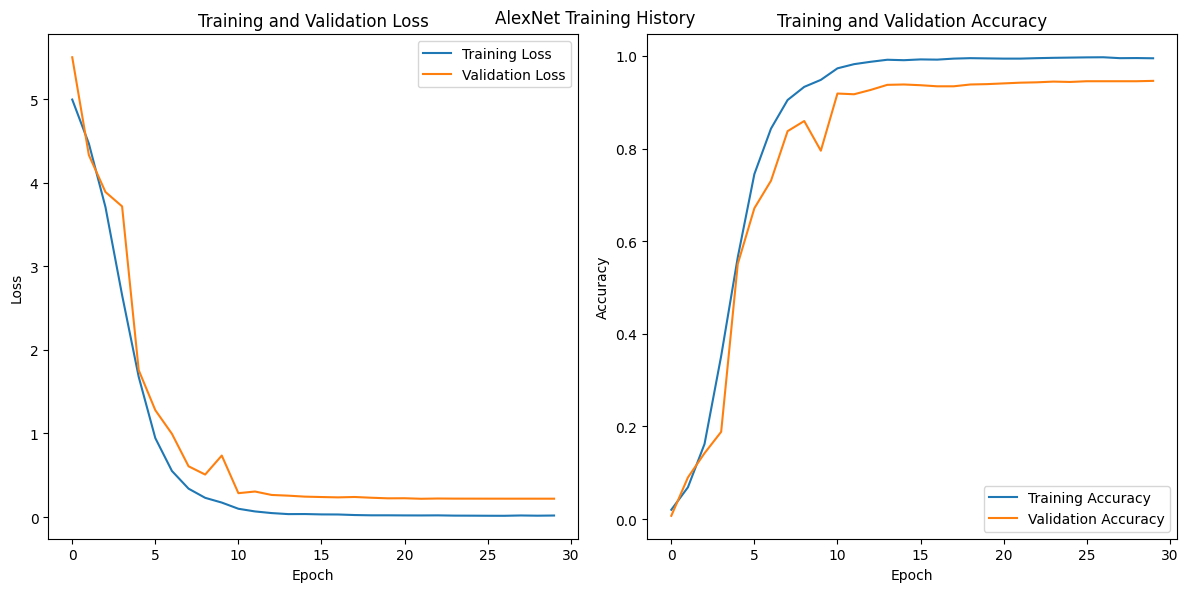

In [9]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/FYODB/AlexNet-95.90%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('AlexNet Training History')
plt.show()


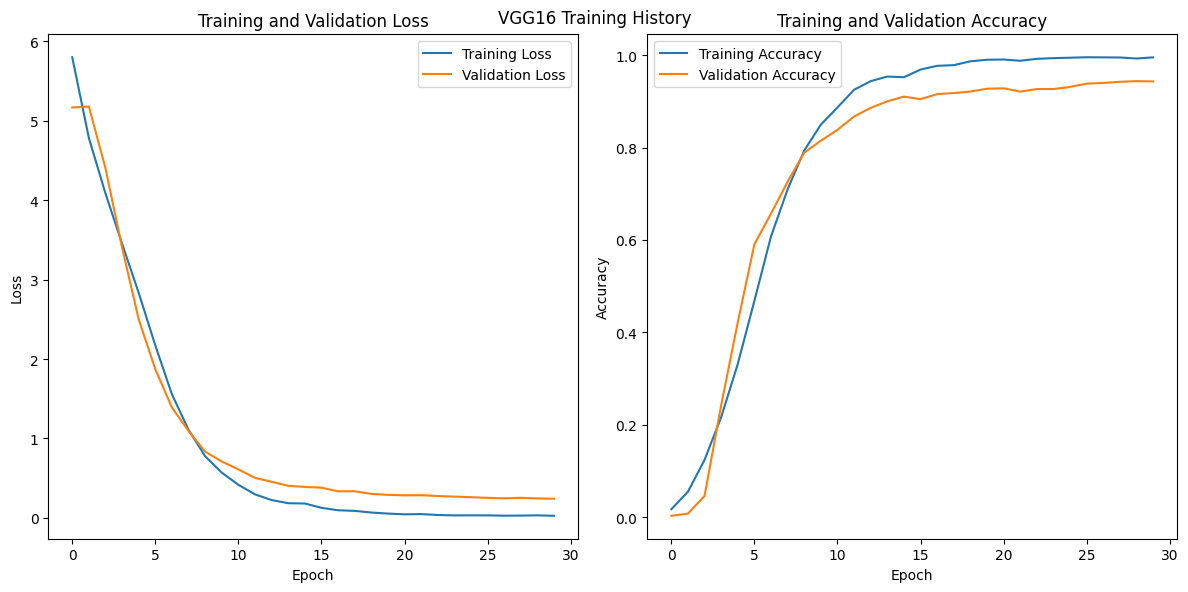

In [10]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/FYODB/VGG16-95.70%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG16 Training History')
plt.show()


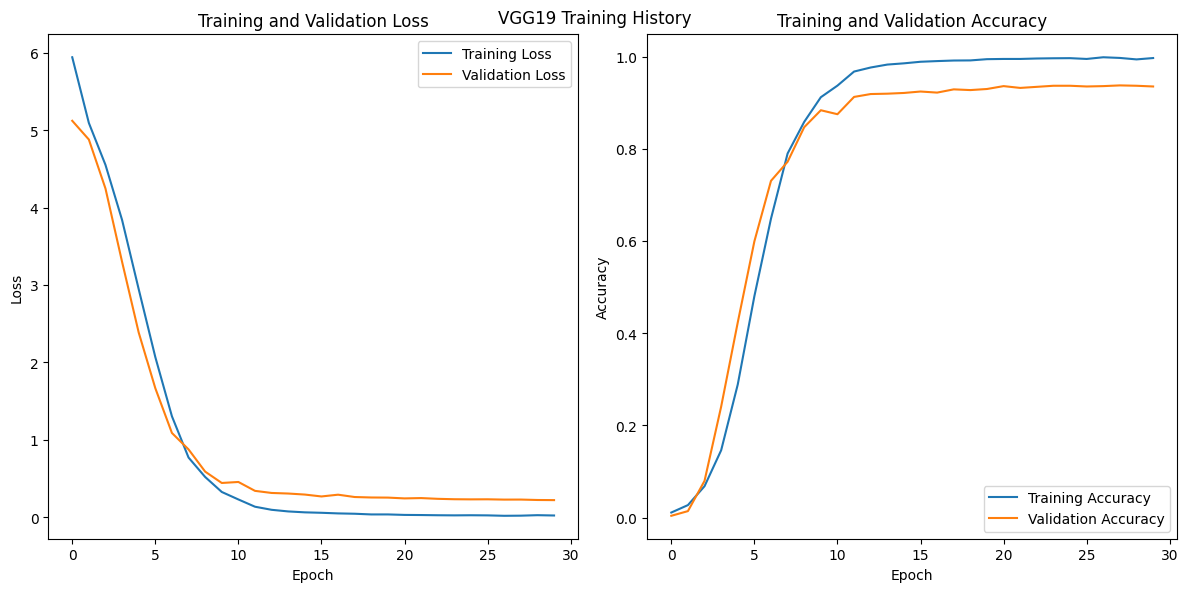

In [11]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/FYODB/VGG19-95.51%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG19 Training History')
plt.show()
